# Hi! In this notebook, I have implemented a model for CIFAR10 dataset, using PyTorch:




### 1- First, importing the necessary libraries:

In [1]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torch import nn
import numpy as np
import time
import gc
import matplotlib.pyplot as plt

### 2- Downloading the dataset, provided by TorchVision:

In [2]:
train_dataset = CIFAR10(root='raw',
                       download=True,
                       train=True,
                       transform=torchvision.transforms.ToTensor())  # Loading as Tensors
test_dataset = CIFAR10(root='raw',
                       download=True,
                       train=False,
                       transform=torchvision.transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 77384237.71it/s]


Extracting raw/cifar-10-python.tar.gz to raw
Files already downloaded and verified


### 3- Investigating a random data from the dataset:

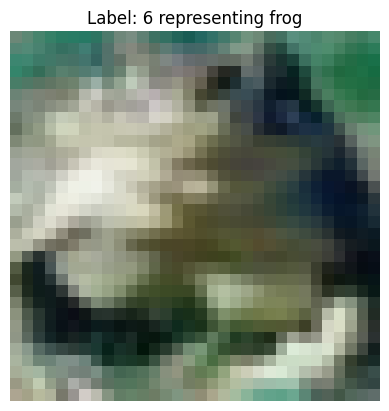

In [3]:
index = np.random.randint(0,train_dataset.data.shape[0])

plt.imshow(train_dataset.data[index])
plt.grid(False)
plt.axis('off')
label = train_dataset.targets[index]
plt.title(f'Label: {label} representing {train_dataset.classes[label]}')
plt.show()

### 4- Visualising the process of convolution on data:

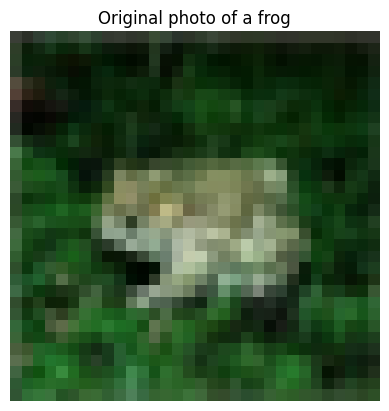


Created convolutions:



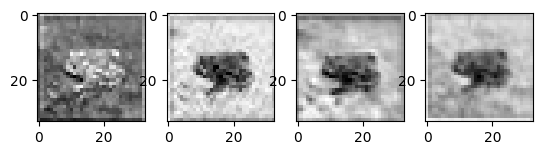

In [4]:
index = np.random.randint(0,train_dataset.data.shape[0])

plt.imshow(torch.tensor(train_dataset.data[index]))    # Original photo
plt.grid(False)
plt.axis('off')
plt.title(f"Original photo of a {train_dataset.classes[train_dataset.targets[index]]}")
plt.show()

temp_tensor = torch.Tensor(train_dataset.data[index]).permute(2,0,1)  # reshaping tensor as input
                                                                      # for Convolutional layer
conv_layer = nn.Conv2d(in_channels=3,
                     out_channels=4,
                     kernel_size=(2,2),
                     stride=1,
                     padding=1)

print('\nCreated convolutions:\n')
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(conv_layer(temp_tensor)[i].detach().numpy(),cmap='gray')
    plt.grid(False)
plt.show()

### 5- Creating the convolutional neural network model:

In [5]:
class CNN_CIFAR10(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256)
        )
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        return self.network(x)

### 6- Checking the non-trained model on the data:

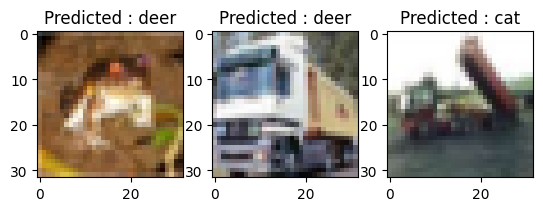

In [6]:
model = CNN_CIFAR10()

for i in range(3):
    temp = model(torch.Tensor(train_dataset.data[i]).permute(2,0,1).unsqueeze(0))
    label = train_dataset.classes[torch.argmax(temp[0])]
    plt.subplot(1,3,i+1)
    plt.imshow(train_dataset.data[i])
    plt.title("Predicted : {}".format(label),fontsize=12)
    plt.grid(False)
plt.show()

### 7- Importing the optimizer and loss function:

In [7]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.001)

### 8- Preprocessing and separating the data:

In [8]:
print('Does x_train track gradients: ',torch.Tensor(train_dataset.data).requires_grad)
x_train = torch.Tensor(train_dataset.data/255).type(torch.float).requires_grad_()

x_test = torch.Tensor(test_dataset.data/255).type(torch.float).requires_grad_()
print('\nDoes x_train track gradients: ',torch.Tensor(x_train).requires_grad)

y_test = torch.nn.functional.one_hot(torch.Tensor(test_dataset.targets).type(torch.LongTensor), num_classes=10)
y_train = torch.nn.functional.one_hot(torch.Tensor(train_dataset.targets).type(torch.LongTensor), num_classes=10)
y_train = y_train.type(torch.float).requires_grad_()
y_test = y_test.type(torch.float).requires_grad_()

Does x_train track gradients:  False

Does x_train track gradients:  True


### 9- Separating a Cross Validation from the data:

In [9]:
x_CV = x_train[45000:]
y_CV = y_train[45000:]
x_train = x_train[:45000]
y_train = y_train[:45000]
x_CV = x_CV.cuda()
y_CV = y_CV.cuda()

### 10- Taking the model and the data to the GPU:

In [10]:
model = model.cuda()
x_train = x_train.cuda()
y_train = y_train.cuda()

### 11- Creating data loaders for each subset of the data:

In [16]:
x_train_loader = torch.utils.data.DataLoader(dataset=x_train,
                                              batch_size=128,
                                              shuffle=False)
y_train_loader = torch.utils.data.DataLoader(dataset=y_train,
                                              batch_size=128,
                                              shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=128,
                                              shuffle=False)

### 12- Defining an accuracy calculator function:

In [12]:
def accuracy(predicted, actual):
    train_correct = torch.eq(predicted.argmax(dim=-1),actual.argmax(dim=-1)).sum().item()
    return (train_correct / len(actual)) * 100


### 13- The training loop with CV:

In [14]:
tic, toc = time.time(), time.time()
epochs, train_accuracy_list, train_loss_list, CV_accuracy_list = [], [], [], []
model.cuda()
for epoch in range(5):

    model.train()

    for x_temp, y_temp in zip(x_train_loader, y_train_loader):

        x_temp = x_temp.cuda()
        y_temp = y_temp.cuda()

        y_pred = model(x_temp.permute(0,3,1,2))

        acc = accuracy(y_pred,y_temp)
        train_accuracy_list.append(acc)

        loss = criterion(y_pred,y_temp)
        train_loss_list.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del x_temp
        del y_temp
        gc.collect()

    epochs.append(epoch)

    y_cv_pred = model(x_CV.permute(0,3,1,2))
    acc_cv = accuracy(y_cv_pred,y_CV)
    CV_accuracy_list.append(acc_cv)
    del y_cv_pred
    gc.collect()

    toc = time.time()

    print(f'epoch {epoch} | loss: {loss:.3f} | train accuracy: % {acc:.4f} | CV accuracy : %{acc_cv:.4f}',
          f'| spent time: {toc-tic:.2f} sec')

    tic = time.time()

epoch 0 | loss: 0.943 | train accuracy: % 68.0556 | CV accuracy : %71.8200 | spent time: 809.12 sec
epoch 1 | loss: 0.697 | train accuracy: % 75.0000 | CV accuracy : %77.3000 | spent time: 806.04 sec
epoch 2 | loss: 0.428 | train accuracy: % 81.9444 | CV accuracy : %79.0600 | spent time: 803.33 sec
epoch 3 | loss: 0.173 | train accuracy: % 91.6667 | CV accuracy : %80.3800 | spent time: 802.83 sec
epoch 4 | loss: 0.126 | train accuracy: % 94.4444 | CV accuracy : %80.2200 | spent time: 799.75 sec


### 14- Saving the trained model:

In [15]:
torch.save(model, 'CIFAR10-Convolution.pth')

### 15- calculating the accuracy for the test set:

In [27]:
accuracies = []
with torch.inference_mode():
    for x_test, y_test in test_loader:
        x_test = x_test.cuda()
        y_test = y_test.cuda()

        y_pred = model(x_test)
        accuracies.append(accuracy(y_pred, torch.nn.functional.one_hot(y_test, 10)))

print(f" accuracy for the test set: {sum(accuracies) / len(accuracies)}")

 accuracy for the test set: 78.42167721518987


### 16- Making the plots special with an extra library (optional)

In [30]:
%pip install mplcyberpunk
import mplcyberpunk
plt.style.use('cyberpunk')

### 17- Plotting the results:

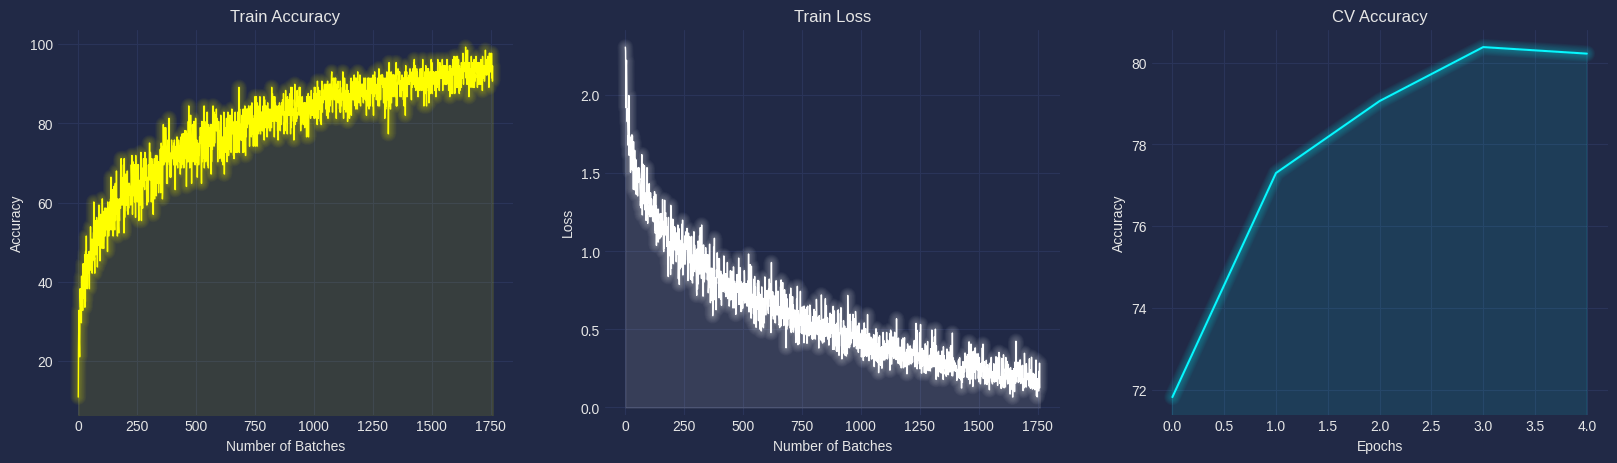

In [43]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.plot([x for x in range(1760)], train_accuracy_list, linewidth=1, c='yellow')
plt.title('Train Accuracy')
plt.xlabel('Number of Batches')
plt.ylabel('Accuracy')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(1, 3, 2)
plt.plot([x for x in range(1760)], [y.cpu().detach().numpy() for y in train_loss_list], linewidth=1, c='white')
plt.title('Train Loss')
plt.xlabel('Number of Batches')
plt.ylabel('Loss')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(1, 3, 3)
plt.plot(epochs, CV_accuracy_list)
plt.title('CV Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.show()